# Structural Similarity

In [2]:
import numpy as np
import pandas as pd
import scipy.spatial as spt
import matplotlib.pyplot as plt
plt.xkcd()
import networkx as nx
%matplotlib inline

## Task 1 - Similarities Calculation

1. Calculate *Euclidean Distance*, *Correlation Coefficient* and *Cosine Distance* for some toy-network (Zachary again?) and for [Les Miserables](http://www-personal.umich.edu/~mejn/netdata/lesmis.zip) dataset
2. Visualize them

**HINT**: For correlation coeficient you can use *np.corrcoef()*, for the distances you may implement them on your own or use *scipy.spatial.distance.pdist()*

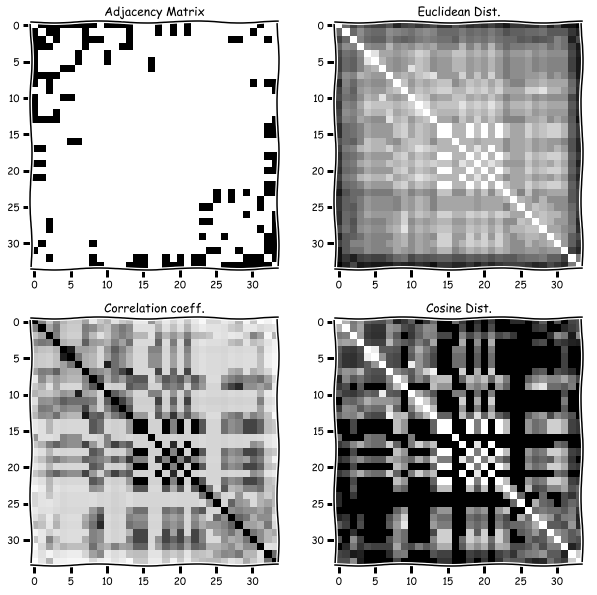

In [98]:
# Put your code here..
#
#
G = nx.karate_club_graph()
A = nx.to_numpy_matrix(G, dtype=int)
A = np.asarray(A)

def plotDist(A):
    
    f, ax = plt.subplots(2, 2, figsize=(10,10))
    ax[0, 0].imshow(A, cmap = 'Greys', interpolation = 'None')
    ax[0, 0].set_title('Adjacency Matrix')
    
    D = np.corrcoef(A)
    ax[1, 0].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[1, 0].set_title('Correlation coeff.')
    
    dVec = spt.distance.pdist(A, metric = 'euclidean')
    D = spt.distance.squareform(dVec)
    ax[0, 1].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[0, 1].set_title('Euclidean Dist.')
    
    dVec = spt.distance.pdist(A, metric = 'cosine')
    D = spt.distance.squareform(dVec)
    ax[1, 1].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[1, 1].set_title('Cosine Dist.')
    
plotDist(A)

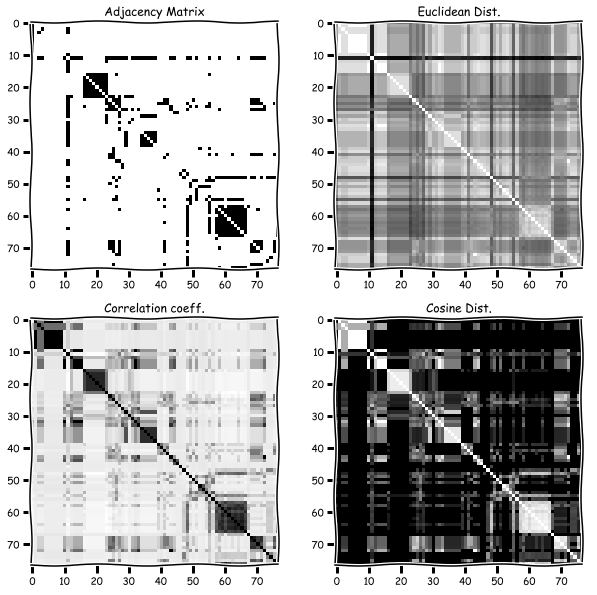

In [5]:
G = nx.read_gml('lesmis.gml')
A = nx.to_numpy_matrix(G, dtype=int)
A = np.asarray(A)

plotDist(A)

## Task 2 - Node Reordering

Without special preprocess procedures graph adjacency matrix can look very noisy and hide network's structure (just look at the matrices above). Offcourse usually you don't know the structure itself (communities, groups of closelly connected nodes, etc.) unless it is given, however there are some procedures of node reordering that provides a better view of the network's adjacency matrix.

[Reverse Cuthill-McKee](http://en.wikipedia.org/wiki/Cuthill%E2%80%93McKee_algorithm) finds permutation of the nodes that minimizes the **bandwidth** of the matrix, which is calculated as: 

$$ \theta = \max_{a_{ij}>0}|i-j|$$

Unformally, this algorithm puts some mass on the diagonal of adjacency matrix.

Run this reordering with *nx.utils.reverse_cuthill_mckee_ordering(G)* and compare with the results above

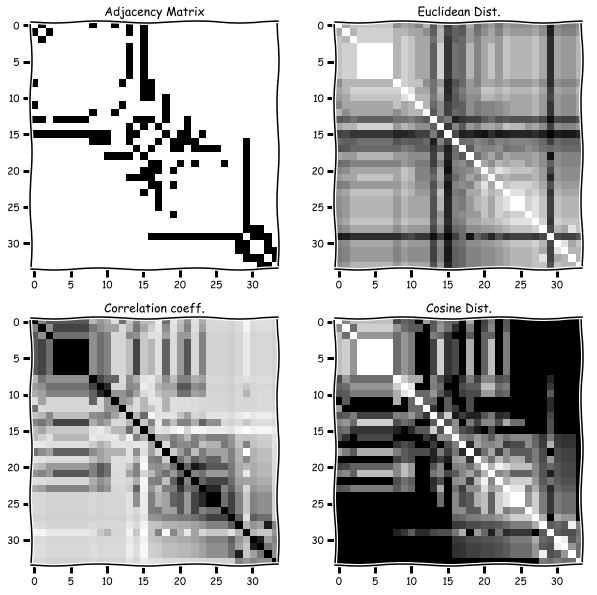

In [6]:
# Put your code here
#
#
G = nx.karate_club_graph()

# run procedure
cm = nx.utils.reverse_cuthill_mckee_ordering(G)
# get permutation
l = [n for n in cm]
l

A = nx.to_numpy_matrix(G)
A = np.asarray(A)
# apply reordering
A = A[np.ix_(l,l)]

plotDist(A)


## Task 3 - Assortative Mixing

For this task you should download some data, convert it to network and calculate assortative mixing coefficient. Particularly, download [GOT data](https://github.com/FutureUnleashed/OSS/tree/master/Neo4j/GOT_Tree): [characters](https://www.hse.ru/data/2016/03/15/1127718485/characters.csv) and [events](https://www.hse.ru/data/2016/03/15/1127718470/events.csv) datasets.

The first dataset provides information on characters of the Game Of Thrones universe. The second one -- describes some events that have occured with them during the story. We are interested in **killing** events since they can be considered as binary relations and consequently -- graphs. The attribute wrt which we are going to compute assortative mixing is called "Team".

We will explore datasets with *pandas* module. The list of usefull functions:

* read_csv()
* characters.head()
* dropna
* set_index('characterID')['Team'].to_dict()
* events[events['event'] == 'killed']

In [4]:
# Put your code here
#
#
events = pd.read_csv('events.csv')
characters = pd.read_csv('characters.csv')

In [5]:
characters.head()

,characterID,Name,Team,isDead,isCaptured,isHurt,title,prefix
0,2,Addam Marbrand,Lannister,0,0,0,knight,Ser
1,1894,Adrack Humble,Greyjoy,0,0,0,NaN,NaN
2,7,Aegon Frey (Jinglebell),Frey (North),0,0,0,NaN,NaN
3,8,Aegon I Targaryen,Targaryen,1,0,0,King of the Seven Kingdoms,King
4,12,Aegon Targaryen,Targaryen,1,0,0,prince,Prince


In [6]:
kill_events = events[events['event'] == 'killed']
kill_events = pd.DataFrame(kill_events, index = None, columns=['characterID', 'event', 'withID'])
kill_events = kill_events.dropna()

In [7]:
kill_events.head()

,characterID,event,withID
7,1808,killed,2068.0
9,1825,killed,1808.0
25,557,killed,456.0
289,1186,killed,1528.0
518,755,killed,629.0


In [8]:
G = nx.DiGraph()

for row, data in kill_events.iterrows():
    killer = data[2]
    killed = data[0]
    G.add_edge(killer, killed)

In [9]:
ch_team = characters.set_index('characterID')['Team'].to_dict()
for k in ch_team.keys():
    if k not in G.nodes():
        del ch_team[k]

In [10]:
nx.set_node_attributes(G, 'Team', ch_team)

In [11]:
nx.assortativity.attribute_assortativity_coefficient(G, 'Team')
as_dict = nx.assortativity.attribute_mixing_dict(G, 'Team')
as_dict

{'Bolton (Lannister)': {},
 'Bolton (North)': {'Bolton (Lannister)': 1,
  'Greyjoy': 1,
  'Stark': 3,
  'none': 1},
 'Brave Companions': {'Lannister': 2, 'none': 1},
 'Citadel': {},
 'Drogo': {'Drogo': 1, 'Targaryen': 1},
 'Essos': {'Targaryen': 2},
 'Faceless Men': {'Citadel': 1, 'Lannister': 2},
 'Frey (Lannister)': {},
 'Frey (North)': {'Stark': 3},
 'Greyjoy': {'Greyjoy': 4,
  'Stark': 4,
  'Tyrell': 1,
  'Wildlings (north of wall)': 1},
 'Lannister': {'Frey (Lannister)': 2,
  'Lannister': 1,
  'Robert': 2,
  'Stark': 4,
  'none': 1},
 'Littlefinger': {'Littlefinger': 1, 'Robert': 1},
 'Martell': {'Robert': 1},
 'Night Watch': {'Night Watch': 4,
  'Tyrell': 1,
  'Wildlings (north of wall)': 5},
 'Red God': {'Renly': 2, 'Stannis': 4},
 'Renly': {'Brave Companions': 3, 'Stark': 1, 'none': 1},
 'Robert': {'Brave Companions': 2,
  'Essos': 1,
  'Martell': 1,
  'Robert': 5,
  'Second Sons': 1,
  'Stark': 4},
 'Second Sons': {},
 'Stannis': {},
 'Stark': {'Bolton (Lannister)': 1,
  'Brav

## Home Task for Testing Assortativity

1. Experiment with GoT data, use different similarity metrics. Explain the results. You may choose another dataset on any TV channel serialization.
2. Find the example of temporal network, that increases assortativity at early stages and became higly disassortative later. Explain this process.
3. Take biological network. Let's prun the largest-degree nodes of a growing scale-free network has the effect of decreasing the degree correlation coefficient (assortativity) in a stable way, while keeping both the trait of a power-law degree distribution and the main properties of network's robustness. Explain the results. Propose a generative model for disassortative growing scale-free networks.

### 1. Experimentation with GoT data

#### Team graph of kills

Firstly, graph from the previous task was transformed to the undirected graph which shows connections between teams based on kills. The team A is connected to the team B if someone from the team A killed someone from the team B or someone from the team B killed someone from the team A.
This graph shows connection between families based on "The blood law".

In [13]:
TG = nx.DiGraph()
for i in range(len(G.edges())):
    ed = G.edges()[i]
    outteam = G.node[ed[0]].values()[0]
    inteam = G.node[ed[1]].values()[0]
    for k in range(len(set(characters['Team']))):
        if list(set(characters['Team']))[k] == outteam:
            outteamid = k
        if list(set(characters['Team']))[k] == inteam:
            inteamid = k
    TG.add_edge(outteamid, inteamid)

In [15]:
TGU = TG.to_undirected()

Secondly, some similarity metrics between teams were calculated and analyzed.

In [288]:
#Jaccard coefficients
preds = nx.jaccard_coefficient(TGU)
edg1 = []
edg2 = []
coef = []
res = []
for u, v, p in preds:
    edg1.append(teams[u])
    edg2.append(teams[v])
    coef.append(p)
teams = list(set(characters['Team']))
while len(res)<=10:
    m = max(coef)
    ind = [k for k, l in enumerate(coef) if l == m]
    for j in range(len(ind)):
        res.append(str(edg1[ind[j]])+'&'+str(edg2[ind[j]])+'  '+str(m))
    for j in range(len(ind)):
        del edg1[ind[j]]
        del edg2[ind[j]]
    coef = filter(lambda a: a != m, coef)
res

['Second Sons&Martell  1.0',
 'Greyjoy&Bolton (Lannister)  0.6',
 'Wildlings (north of wall)&Bolton (North)  0.6',
 'Second Sons&Essos  0.5',
 'Second Sons&Littlefinger  0.5',
 'Frey (North)&Frey (Lannister)  0.5',
 'Essos&Martell  0.5',
 'Martell&Littlefinger  0.5',
 'Renly&Lannister  0.4',
 'Brave Companions&Frey (Lannister)  0.4',
 'Renly&Night Watch  0.375',
 'Greyjoy&Night Watch  0.375']

In [289]:
#Cosine metrics
A = nx.to_numpy_matrix(TGU, dtype=int)
A = np.asarray(A)
edg1 = []
edg2 = []
coef = []
res = []
teams = list(set(characters['Team']))
for i in range(len(A)):
    for j in range(i, len(A[i])):
        if teams[TGU.nodes()[i]]!=teams[TGU.nodes()[j]]:
            edg1.append(teams[TGU.nodes()[i]])
            edg2.append(teams[TGU.nodes()[j]])
            coef.append(1-spt.distance.cosine(A[i], A[j]))
while len(res)<=10:
    m = max(coef)
    ind = [k for k, l in enumerate(coef) if l == m]
    for j in range(len(ind)):
        res.append(str(edg1[ind[j]])+'&'+str(edg2[ind[j]])+'  '+str(m))
    for j in range(len(ind)):
        del edg1[ind[j]]
        del edg2[ind[j]]
    coef = filter(lambda a: a != m, coef)
res

['Second Sons&Martell  1.0',
 'Greyjoy&Bolton (Lannister)  0.774596669241',
 'Wildlings (north of wall)&Bolton (North)  0.75',
 'Stark&none  0.707106781187',
 'Second Sons&Essos  0.707106781187',
 'Second Sons&Littlefinger  0.707106781187',
 'Frey (North)&Frey (Lannister)  0.707106781187',
 'Essos&Martell  0.707106781187',
 'Martell&Littlefinger  0.707106781187',
 'none&Brave Companions  0.676123403783',
 'Brave Companions&Frey (Lannister)  0.632455532034']

In [88]:
#Correlation coefficients
A = nx.to_numpy_matrix(TGU, dtype=int)
A = np.asarray(A)
edg1 = []
edg2 = []
coef = []
res = []
teams = list(set(characters['Team']))
for i in range(len(A)):
    for j in range(i, len(A[i])):
        if teams[TGU.nodes()[i]]!=teams[TGU.nodes()[j]]:
            edg1.append(teams[TGU.nodes()[i]])
            edg2.append(teams[TGU.nodes()[j]])
            coef.append(1-spt.distance.correlation(A[i], A[j]))
while len(res)<=10:
    m = max(coef)
    ind = [k for k, l in enumerate(coef) if l == m]
    for j in range(len(ind)):
        res.append(str(edg1[ind[j]])+'&'+str(edg2[ind[j]])+'  '+str(m))
    for j in range(len(ind)):
        del edg1[ind[j]]
        del edg2[ind[j]]
    coef = filter(lambda a: a != m, coef)
res

['Second Sons&Martell  1.0',
 'Greyjoy&Bolton (Lannister)  0.74296702484',
 'Wildlings (north of wall)&Bolton (North)  0.708333333333',
 'Frey (North)&Frey (Lannister)  0.693888666489',
 'Second Sons&Littlefinger  0.693888666489',
 'Martell&Littlefinger  0.693888666489',
 'Second Sons&Essos  0.693888666489',
 'Essos&Martell  0.693888666489',
 'Brave Companions&Frey (Lannister)  0.594849690129',
 'none&Brave Companions  0.592220092264',
 'Stark&none  0.57735026919']

It can be seen that the first three pairs of teams are the same for all three metrics: Jaccard, Cosine and correlation. (Actually, I don't remember the team "Second Sons" and can't analyze it properly.)

* Greyjoy & Bolton(Lannister) are similar because they acted quite similarly trying to occupy the North.
* Wildlings(north of wall) & Bolton(North) are similar because of location.
* It can be seen that Frey(North) & Frey(Lannister) acted similarly despite the fact that they changed the side.

#### Team graph of marriage

Firstly, the undirected graph which shows connections between teams based on marriages or engagements should be built. The team A is connected to the team B if someone from the team A is married or engaged with someone from the team B or someone from the team B is married or engaged with someone from the team A. 

In [96]:
marr_events = events[events['event'] == 'married']
marr_events = pd.DataFrame(marr_events, index = None, columns=['characterID', 'event', 'withID'])
marr_events = marr_events.dropna()

G = nx.DiGraph()

for row, data in marr_events.iterrows():
    marr1 = data[2]
    marr2 = data[0]
    G.add_edge(marr1, marr2)
ch_team = characters.set_index('characterID')['Team'].to_dict()
for k in ch_team.keys():
    if k not in G.nodes():
        del ch_team[k]
nx.set_node_attributes(G, 'Team', ch_team)        
marr_events = events[events['event'] == 'engaged']
marr_events = pd.DataFrame(marr_events, index = None, columns=['characterID', 'event', 'withID'])
marr_events = marr_events.dropna()

for row, data in marr_events.iterrows():
    marr1 = data[2]
    marr2 = data[0]
    G.add_edge(marr1, marr2)
ch_team = characters.set_index('characterID')['Team'].to_dict()
for k in ch_team.keys():
    if k not in G.nodes():
        del ch_team[k]
nx.set_node_attributes(G, 'Team', ch_team)
MG = nx.DiGraph()
for i in range(len(G.edges())):
    ed = G.edges()[i]
    outteam = G.node[ed[0]].values()[0]
    inteam = G.node[ed[1]].values()[0]
    for k in range(len(set(characters['Team']))):
        if list(set(characters['Team']))[k] == outteam:
            outteamid = k
        if list(set(characters['Team']))[k] == inteam:
            inteamid = k
    MG.add_edge(outteamid, inteamid)
    
MGU = MG.to_undirected()

Secondly, some similarity metrics were calculated and analyzed.

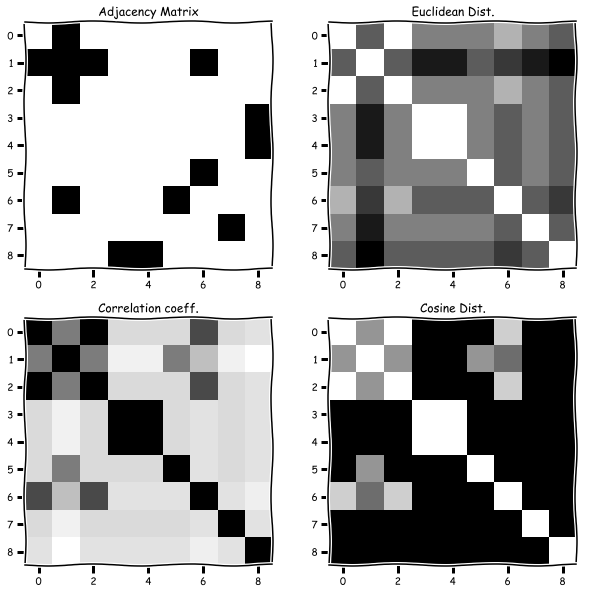

In [99]:
A = nx.to_numpy_matrix(MGU, dtype=int)
A = np.asarray(A)
plotDist(A)

In [300]:
#Jaccard metrics
A = nx.to_numpy_matrix(MGU, dtype=int)
A = np.asarray(A)
edg1 = []
edg2 = []
coef = []
res = []
teams = list(set(characters['Team']))
for i in range(len(A)):
    for j in range(i, len(A[i])):
        if teams[MGU.nodes()[i]]!=teams[MGU.nodes()[j]]:
            edg1.append(teams[MGU.nodes()[i]])
            edg2.append(teams[MGU.nodes()[j]])
            coef.append(1-spt.distance.jaccard(A[i], A[j]))
d = {'teamA': edg1, 'teamB': edg2, 'coefficient': coef}
df = pd.DataFrame(data=d)
df1 = df.sort_values(by = ['coefficient', 'teamA', 'teamB'], ascending=False)
df1.head()

,coefficient,teamA,teamB
1,1.00,Stannis,Tyrion
21,1.00,Drogo,Essos
18,0.50,Tyrion,Lannister
5,0.50,Stannis,Lannister
8,0.25,Stark,Tyrion


In [301]:
#Cosine metrics
A = nx.to_numpy_matrix(MGU, dtype=int)
A = np.asarray(A)
edg1 = []
edg2 = []
coef = []
res = []
teams = list(set(characters['Team']))
for i in range(len(A)):
    for j in range(i, len(A[i])):
        if teams[MGU.nodes()[i]]!=teams[MGU.nodes()[j]]:
            edg1.append(teams[MGU.nodes()[i]])
            edg2.append(teams[MGU.nodes()[j]])
            coef.append(1-spt.distance.cosine(A[i], A[j]))
d = {'teamA': edg1, 'teamB': edg2, 'coefficient': coef}
df = pd.DataFrame(data=d)
df1 = df.sort_values(by = ['coefficient', 'teamA', 'teamB'], ascending=False)
df1.head()

,coefficient,teamA,teamB
1,1.000000,Stannis,Tyrion
21,1.000000,Drogo,Essos
18,0.707107,Tyrion,Lannister
5,0.707107,Stannis,Lannister
8,0.500000,Stark,Tyrion


In [302]:
#Correlation metrics
A = nx.to_numpy_matrix(MGU, dtype=int)
A = np.asarray(A)
edg1 = []
edg2 = []
coef = []
res = []
teams = list(set(characters['Team']))
for i in range(len(A)):
    for j in range(i, len(A[i])):
        if teams[MGU.nodes()[i]]!=teams[MGU.nodes()[j]]:
            edg1.append(teams[MGU.nodes()[i]])
            edg2.append(teams[MGU.nodes()[j]])
            coef.append(1-spt.distance.correlation(A[i], A[j]))
d = {'teamA': edg1, 'teamB': edg2, 'coefficient': coef}
df = pd.DataFrame(data=d)
df1 = df.sort_values(by = ['coefficient', 'teamA', 'teamB'], ascending=False)
df1.head()

,coefficient,teamA,teamB
1,1.000000,Stannis,Tyrion
21,1.000000,Drogo,Essos
18,0.661438,Tyrion,Lannister
5,0.661438,Stannis,Lannister
8,0.395285,Stark,Tyrion


It can be seen that top 5 team pairs are the same for all three metrics: Jaccard, Cosine and correlation.
What is more, it can be seen that teams "Tyrion", "Stannis" and "Lannister" are similar to each other. It means that all of them tried to set connections (based on marriage) with the same teams.

But since this graph is quite small analysis is not very interesting.

### 2. Mixing assortativity

This strategy (temporal network which increases assortativity at early stages and became higly disassortative later) was implemented by Barabasi-Albert model on the Erdos-Reni graph with nodes=100, p=0.01.

The start graph is quite sparse.
On each step 1 node with m edges is added preferentially. 

At early stages 

* the highest degree is small and quite achievable,
* "old" nodes are connected and become more and more popular on every step.

Consequently, graph is assortative at these stages.

And later

* every new node connects to nodes with high degree.

Hence, graph becomes disassortative.

This can be shown on the plot below.

In [384]:
def mixing_graph(n, m):   
    G=nx.fast_gnp_random_graph(100, 0.01)
    assort = []
    
    targets=list(range(m))
    repeated_nodes=[]
    source=n-100
    while source<n:
        G.add_edges_from(zip([source]*m,targets))
        repeated_nodes.extend(targets)
        repeated_nodes.extend([source]*m)
        targets = np.random.choice(repeated_nodes,m)
        if source%1 == 0:
            assort.append(np.average(nx.degree_assortativity_coefficient(G)))
        source += 1
    return G, assort

In [385]:
[H, a] = mixing_graph(1000, 10)

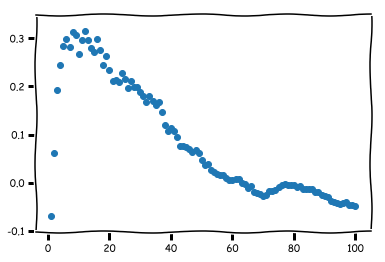

In [387]:
plt.scatter(range(1,101,1), a)
plt.show()

### 3. Biological network

#### Pruning of high degree

Since the BA model is scale-free it was used for this task.

The starting point is BA graph with nodes=1000, m=5. Then on each step nodes with the highest degree are removed and new nodes are attached preferentially instead of removed ones.

It can be seen on the plot below that graphs on the every step are scale-free. What is more, it can be seen that assortativity coefficient decreases.

In [391]:
def scale_free_g(m, G):
    deg = G.degree()
    m = max(deg.values())
    n = len([k for k, l in enumerate(deg.values()) if l == m])
    for j in range(len(deg)):
        if deg.values()[j]==m:
            G.remove_node(deg.keys()[j])

    targets=list(range(m))
    repeated_nodes=[]
    source=m
    while source<n:
        G.add_edges_from(zip([source]*m,targets))
        repeated_nodes.extend(targets)
        repeated_nodes.extend([source]*m)
        targets = np.random.choice(repeated_nodes,m)
        source += 1
    return G

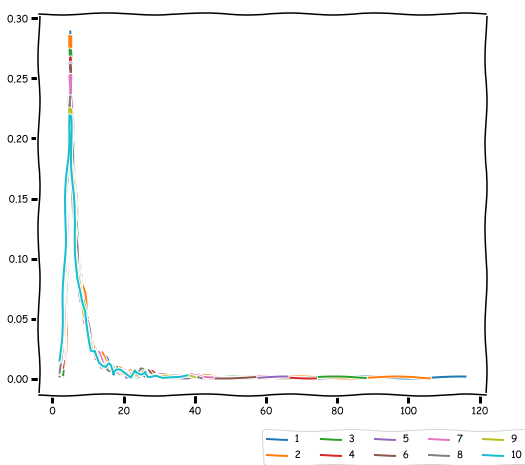

In [145]:
G =nx.barabasi_albert_graph(1000, 5)
degr = []
probb = []
assort = []
for i in range(20):
    if i%2==0:
        k = G.degree()
        nod = nx.number_of_nodes(G)
        k_sort = np.array(k.values())
        kset = list(set(k_sort))


        deg = [0]*len(kset)
        for i in range(len(kset)):
            for j in range(len(k_sort)):
                if k_sort[j]==kset[i]:
                    deg[i]=deg[i]+1

        for i in range(len(deg)):     
            deg[i] = float(deg[i])/float(nod)
        degr.append(kset)
        probb.append(deg)
    assort.append(np.average(nx.degree_assortativity_coefficient(G)))
    G = scale_free_g(5, G)

fig = plt.figure(1, figsize=(8,7))
ax = plt.subplot(111)
l1, l2, l3, l4, l5, l6, l7, l8, l9, l10 = ax.plot(degr[0], probb[0], 
                     degr[1], probb[1], 
                     degr[2], probb[2], 
                     degr[3], probb[3], 
                     degr[4], probb[4], 
                     degr[5], probb[5], 
                     degr[6], probb[6], 
                     degr[7], probb[7], 
                     degr[8], probb[8], 
                     degr[9], probb[9] )
fig.legend((l1, l2, l3, l4, l5, l6, l7, l8, l9, l10), ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10'), 
           loc = (0.5, 0), ncol=5 )
plt.show()

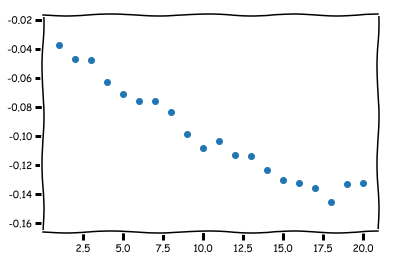

In [393]:
plt.scatter(range(1,21), assort)
plt.show()

#### Disassortative growing scale-free network

The starting point of the model is BA with nodes=1000, m=3. On every time step 10 nodes are added with modified preferential attachment: if degree of the node is average the probability of connection with this node is high, if degree is low or high the probability of connection is low.

It can be seen below that on every time step the graph is scale-free. And it can be seen below that on every time step disassortativity increses.

In [394]:
def avgpref_attachment(n, m, G):
    targets=list(range(m))
    repeated_nodes=[]
    source=0
    while source<n:
        G.add_edges_from(zip([source]*m,targets))
        repeated_nodes.extend(targets)
        repeated_nodes.extend([source]*m)
        deg = G.degree()
        degv = deg.values()
        prob = [0.0]*len(deg)
        avgv = float(np.percentile(degv, 50))
        maxv = float(max(degv))
        minv = float(min(degv))
        for i in range(len(deg)):
            if degv[i]>=avgv:
                prob[i] = np.abs(float(degv[i])-maxv)/(maxv-minv)
            if degv[i]<avgv:
                prob[i] = (float(degv[i])-minv)/(maxv-minv)
        a = 0.0
        for i in range(len(deg)):
            a = a + prob[i]
        a = float(1)/a
        prob1 = []
        for i in range(len(deg)):
            prob1.append(a*(np.float64(prob[i])))
        targets = np.random.choice(deg.keys(), size=m, p=prob1)
        source += 1
    return G

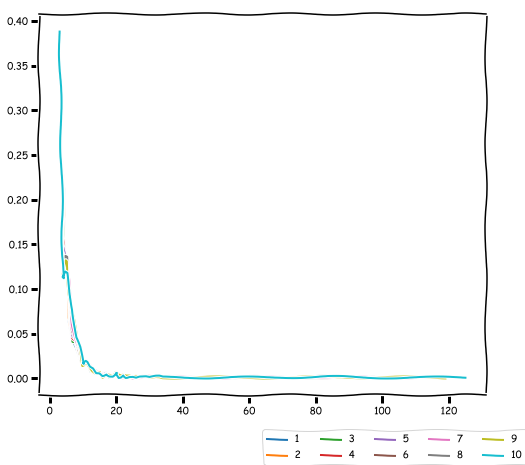

In [280]:
G = nx.barabasi_albert_graph(1000, 3)
degr = []
probb = []
assort = []
for i in range(20):
    if i%2==0:
        k = G.degree()
        nod = nx.number_of_nodes(G)
        k_sort = np.array(k.values())
        kset = list(set(k_sort))


        deg = [0]*len(kset)
        for i in range(len(kset)):
            for j in range(len(k_sort)):
                if k_sort[j]==kset[i]:
                    deg[i]=deg[i]+1

        for i in range(len(deg)):     
            deg[i] = float(deg[i])/float(nod)
        degr.append(kset)
        probb.append(deg)
    assort.append(np.average(nx.degree_assortativity_coefficient(G)))
    G = avgpref_attachment(10, 3, G)

fig = plt.figure(1, figsize=(8,7))
ax = plt.subplot(111)
l1, l2, l3, l4, l5, l6, l7, l8, l9, l10 = ax.plot(degr[0], probb[0], 
                     degr[1], probb[1], 
                     degr[2], probb[2], 
                     degr[3], probb[3], 
                     degr[4], probb[4], 
                     degr[5], probb[5], 
                     degr[6], probb[6], 
                     degr[7], probb[7], 
                     degr[8], probb[8], 
                     degr[9], probb[9] )
fig.legend((l1, l2, l3, l4, l5, l6, l7, l8, l9, l10), ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10'), 
           loc = (0.5, 0), ncol=5 )
plt.show()

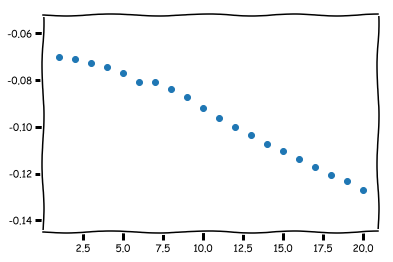

In [282]:
plt.scatter(range(1, 21), assort)
plt.show()